In [68]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [69]:
# img = cv2.imread("roadlanes2.jpeg")
cap1 = cv2.VideoCapture('E:\Lane Detection March 2022\highway3.mp4')
ret, img = cap1.read()

In [70]:
height = img.shape[0]
width = img.shape[1]


#Lower 40% of the frame
pts40 = np.float32([[0, height], [width, height],
                   [width, int(height*0.6)], [0, int(height*0.6)]])
                [int(width*.4), int(height*0.6)], [int(width*0.6), int(height*0.6)]])

pts1 = np.float32([[0, height], [width, height],
                  [int(width*.45), int(height*0.5)], [int(width*.65), int(height*0.5)]])


pts2 = np.float32([[0, height], [width, height],
                    [0, 0], [width, 0]])

vertices1 = [[width/3, height], [width/3, 0], [width*2/3, 0],
                    [width*2/3, height]]

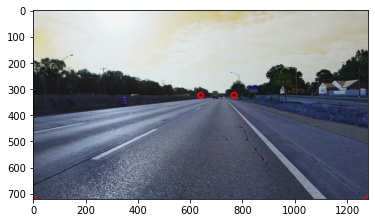

In [71]:
# Check points on a single frame

pts_new = [[0, height], [width, height],
                  [int(width*.5), int(height*0.45)], [int(width*.6), int(height*0.45)]]
img3 = np.copy(img)
for pt in pts_new:
    cv2.circle(img=img3, center = (pt[0], pt[1]), radius = 10, color =(255,0,0), thickness=5)
plt.imshow(img3)

In [72]:
def increase_contrast(image):
    #-----Converting image to LAB Color model----------------------------------- 
    lab= cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    
    #-----Splitting the LAB image to different channels-------------------------
    l, a, b = cv2.split(lab)

    #-----Applying CLAHE to L-channel-------------------------------------------
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    cl = clahe.apply(l)

    #-----Merge the CLAHE enhanced L-channel with the a and b channel-----------
    limg = cv2.merge((cl,a,b))

    #-----Converting image from LAB Color model to RGB model--------------------
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    
    return final
    #_____END_____#

In [74]:
cap = cv2.VideoCapture('E:\Lane Detection March 2022\highway3.mp4')

height = 720
width = 1280
while cap.isOpened():
    ret, img = cap.read()
    if img is not None:
        
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        blur = cv2.GaussianBlur(gray, (9,9), cv2.BORDER_DEFAULT)
#         contrast = increase_contrast(blur)
        canny = cv2.Canny(blur, 100, 120)
        matrix = cv2.getPerspectiveTransform(pts1, pts2)
        BEV = cv2.warpPerspective(canny, matrix, (width, height))
        BEV_img = cv2.warpPerspective(img, matrix, (width, height))
        
        lines = cv2.HoughLinesP(BEV,
                            rho=2,
                            theta=np.pi/180,
                            threshold=200,
                            lines=np.array([]),
                            minLineLength=150,
                            maxLineGap=350)
        
        BEV_blank_image_with_lines = np.zeros((height, width, 3), dtype=np.uint8)
    
        if lines is not None:
            start_x, start_y = lines[0][0][0], lines[0][0][1]
            end_x, end_y = 0, 0

            for line in lines:
                for x1, y1, x2, y2 in line:
                    end_x, end_y = x2, y2
                    cv2.line(BEV_blank_image_with_lines, (x1,y1), (x2,y2), (0, 255, 0), thickness=5)

#             cv2.rectangle(BEV_blank_image_with_lines, (start_x, start_y), (end_x, end_y), (200, 0, 0), cv2.FILLED)
        
    
        matrix = cv2.getPerspectiveTransform(pts2, pts1)
        lines_correct_pers = cv2.warpPerspective(BEV_blank_image_with_lines, matrix, (width, height))
        img_with_lines = cv2.addWeighted(img, 0.8, lines_correct_pers, 1, 0.0)
        
        
        cv2.imshow('canny', img_with_lines)
        cv2.imshow('frame', img)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()